# Dataset

In [1]:
from torch.utils.data import Dataset, DataLoader
import os
import pickle
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from EncoderCNN import Encoder
from ConvRNN import ConvLSTM
from Decoder import Decoder
from torchvision.utils import make_grid
import torch.optim as optim
from tqdm import tqdm
from MotionEncoder import MotionEncoder
from CameraEncoder import CameraEncoder
from RNN import EgoMotionRNN
from CameraDecoder import CameraDecoder
from DepthMap import DepthDecoder
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import random
from PIL import ImageDraw, ImageFilter
import torch.nn.functional as F


### Transforms Functions for Dataset Loading

In [2]:
transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.Resize((256, 512)),
    transforms.ToTensor(),
])

In [3]:
def transform_segmentation_target(image):
    """
    Transform a segmentation image to a tensor with class labels based on the red channel encoding.
    """
    img_array = np.array(image, dtype=np.int64)
    label = img_array[:, :, 0]  # Extract the red channel as the label

    # Map the red channel to class labels based on the dataset's specifications
    label_map = {
    0: 0,   # Unlabeled
    1: 1,   # Building
    2: 2,   # Fence
    3: 3,   # Other
    4: 4,   # Pedestrian
    5: 5,   # Pole
    6: 6,   # RoadLine
    7: 7,   # Road
    8: 8,   # SideWalk
    9: 9,   # Vegetation
    10: 10, # Vehicles
    11: 11, # Wall
    12: 12, # TrafficSign
    13: 13, # Sky
    14: 14, # Ground
    15: 15, # Bridge
    16: 16, # RailTrack
    17: 17, # GuardRail
    18: 18, # TrafficLight
    19: 19, # Static
    20: 20, # Dynamic
    21: 21, # Water
    22: 22, # Terrain
}
    label_tensor = torch.from_numpy(np.vectorize(label_map.get)(label))

    return label_tensor

In [4]:
target_transform = transforms.Compose([
    transforms.Resize((256, 512)), 
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.Lambda(lambda img: transform_segmentation_target(img)),
])

In [5]:
depth_transform = transforms.Compose([
    transforms.Resize((256, 512)), 
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),  
    # Normalize depth values if necessary. This is just an example; adjust according to your depth data range.
    #transforms.Normalize(mean=[0.5], std=[0.5])
])

In [6]:
# Define the root dataset path
root_dataset_path = '/home/user/asifa0/Project/CARLABase'

#### Functions to Corrupt BASE CARLA

In [7]:
def add_gaussian_noise(image):
    row, col, ch = image.shape
    mean = 0
    var = 0.1
    sigma = var ** 0.05
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    gauss = gauss.reshape(row, col, ch)
    noisy = image + gauss
    noisy = np.clip(noisy, 0, 255)  
    return noisy.astype(np.uint8)  

def add_clutter(image):
    draw = ImageDraw.Draw(image)
    number_of_shapes = random.randint(1, 5)  
    for _ in range(number_of_shapes):
        x1, y1 = random.randint(0, image.size[0] - 1), random.randint(0, image.size[1] - 1)
        x2, y2 = random.randint(0, image.size[0] - 1), random.randint(0, image.size[1] - 1)
        draw.line((x1, y1, x2, y2), fill='white', width=2)
    return image

def change_illumination(image):
    new_image = image.astype(np.float64) * (0.6 + np.random.random() * 0.8)  
    new_image = np.clip(new_image, 0, 255)  
    return new_image.astype(np.uint8)  

def add_motion_blur(image, angle, radius):
    # Apply motion blur to the image using PIL's ImageFilter.
    image = image.filter(ImageFilter.GaussianBlur(radius=radius))
    return image.rotate(angle, resample=Image.BICUBIC).filter(ImageFilter.GaussianBlur(radius)).rotate(-angle, resample=Image.BICUBIC)

def add_low_light_effect(image, factor):
    # Multiply the image with a factor to simulate low light conditions.
    new_image = image.astype(np.float64) * factor  
    new_image = np.clip(new_image, 0, 255)
    return new_image.astype(np.uint8)

def add_overexposure_effect(image, factor):
    # Add a constant value to simulate overexposure.
    new_image = image.astype(np.float64) + factor * 255  
    new_image = np.clip(new_image, 0, 255)
    return new_image.astype(np.uint8)


## Iterating over Directories, Loading Images and Creating Tensors

In [8]:
class SequentialImagesDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None, depth_transform=None, apply_corruption=False, include_towns=None, exclude_towns=None):
        
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform 
        self.depth_transform = depth_transform 
        self.include_towns = include_towns
        self.exclude_towns = exclude_towns
        self.sequences = self._load_sequences()
        self.apply_corruption = apply_corruption

    def _load_sequences(self):
        sequences = []
        for town in sorted(os.listdir(self.root_dir)):
            if self.include_towns and town not in self.include_towns:
                continue
            if self.exclude_towns and town in self.exclude_towns:
                continue
            town_path = os.path.join(self.root_dir, town)
            if os.path.isdir(town_path):
                for sequence in sorted(os.listdir(town_path)):
                    sequence_path = os.path.join(town_path, sequence)
                    if os.path.isdir(sequence_path):
                        # Filter files to include only those that match the expected pattern
                        valid_files = [f for f in os.listdir(sequence_path) if f.startswith('img_') and f.endswith('.png') and any(char.isdigit() for char in f)]
                        if valid_files:
                            # Sort the files based on the numeric part of the filename
                            images = sorted(valid_files, key=lambda f: int(''.join(filter(str.isdigit, f))))
                            images = [os.path.join(sequence_path, f) for f in images]
                            sequences.append(images)
        return sequences

    def __len__(self):
        return len(self.sequences)
    

    def __getitem__(self, idx):
        image_paths = self.sequences[idx]
        optical_flow_paths = [p.replace('img_', 'optical_flow_').replace('.png', '.npy') for p in image_paths]
        segmentation_paths = [p.replace('img_', 'segmentation_') for p in image_paths]
        depth_paths = [p.replace('img_', 'depth_') for p in image_paths]
        
        
        sequence_tensors = []
        segmentation_tensors = []
        depth_tensors = []
        optical_flow_tensors = []
        
        # Load input Images and optical_flow files
        for image_path, optical_flow_path in zip(image_paths, optical_flow_paths):
            try:
                img = Image.open(image_path).convert('RGB')
                if self.apply_corruption:
                    img = np.array(img)
                    img = add_gaussian_noise(img)
                    # Overexposure effect
                    factor = random.uniform(0.1, 0.3)
                    img = add_overexposure_effect(np.array(img), factor)
                    img = Image.fromarray(img, 'RGB') 
                    #img = add_clutter(img)
                    # Apply motion blur
                    angle = random.uniform(0, 0.5)
                    radius = random.uniform(2, 6)
                    img = np.array(img)
                    img = add_motion_blur(Image.fromarray(img), angle, radius)
                    img = np.array(img)  
                    img = change_illumination(img)
                    img = Image.fromarray(img, 'RGB')
                if self.transform:
                    img = self.transform(img)
                sequence_tensors.append(img)
                optical_flow = np.load(optical_flow_path)
                optical_flow_tensor = torch.from_numpy(optical_flow).permute(2, 0, 1) # Assuming optical flow has shape (H, W, 2)
                optical_flow_tensors.append(optical_flow_tensor)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
                sequence_tensors.append(torch.zeros((3, 256, 512)))
                optical_flow_tensors.append(torch.zeros((2, 256, 512)))

        
        # Load camera extrinsics for the sequence
        meta_path = os.path.join(os.path.dirname(image_paths[0]), 'meta.pkl')
        with open(meta_path, 'rb') as f:
            meta_data = pickle.load(f)
        extrinsics = torch.tensor(meta_data['extrinsics'][:6], dtype=torch.float32)
        
        # Segmented images loading
        
        for seg_path in segmentation_paths:
            try:
                with Image.open(seg_path) as seg:
                    if self.target_transform:
                        seg = self.target_transform(seg)
                    segmentation_tensors.append(seg)
            except Exception as e:
                print(f"Error loading segmentation image {seg_path}: {e}")
                
        # Load depth maps
        for depth_path in depth_paths:
            try:
                with Image.open(depth_path) as depth:
                    if self.depth_transform:
                        depth = self.depth_transform(depth)
                    depth_tensors.append(depth)
            except Exception as e:
                print(f"Error loading depth image {depth_path}: {e}")
                

        sequence_tensor = torch.stack(sequence_tensors) if sequence_tensors else torch.zeros((6, 3, 256, 512))
        optical_flow_tensor = torch.stack(optical_flow_tensors) if optical_flow_tensors else torch.zeros((6, 2, 256, 512))
        depth_tensor = torch.stack(depth_tensors) if depth_tensors else torch.zeros((6, 1, 256, 512))
        segmentation_tensor = torch.stack(segmentation_tensors) if segmentation_tensors else torch.zeros((6, 23, 256, 512))

        return sequence_tensor, optical_flow_tensor, segmentation_tensor, extrinsics, depth_tensor



##### BASE CARLA

In [10]:
# Initialize the dataset for training, validation, and testing
org_train_dataset = SequentialImagesDataset(root_dataset_path, transform=transform, target_transform=target_transform, depth_transform=depth_transform, apply_corruption=True, exclude_towns=['Town02', 'Town10'])
org_val_dataset = SequentialImagesDataset(root_dataset_path, transform=transform, target_transform=target_transform, depth_transform=depth_transform, apply_corruption=True, include_towns=['Town02'])
org_test_dataset = SequentialImagesDataset(root_dataset_path, transform=transform, target_transform=target_transform, depth_transform=depth_transform, apply_corruption=True, include_towns=['Town10'])

In [11]:
# DataLoaders for each set
org_train_loader = DataLoader(org_train_dataset, batch_size=1, shuffle=False, num_workers=4)
org_val_loader = DataLoader(org_val_dataset, batch_size=1, shuffle=False, num_workers=4)
org_test_loader = DataLoader(org_test_dataset, batch_size=1, shuffle=False, num_workers=4)

##### Corrupted CARLA

In [12]:
# Initialize the dataset for training, validation, and testing
train_dataset = SequentialImagesDataset(root_dataset_path, transform=transform, target_transform=target_transform, depth_transform=depth_transform, apply_corruption=False, exclude_towns=['Town02', 'Town10'])
val_dataset = SequentialImagesDataset(root_dataset_path, transform=transform, target_transform=target_transform, depth_transform=depth_transform, apply_corruption=False, include_towns=['Town02'])
test_dataset = SequentialImagesDataset(root_dataset_path, transform=transform, target_transform=target_transform, depth_transform=depth_transform, apply_corruption=False, include_towns=['Town10'])

In [13]:
# DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

In [14]:
print(len(train_loader))
for sequence_tensor, optical_flow, segmentation_tensor, extrinsics, depth_tensor in train_loader:
    print(sequence_tensor.shape)
    print(optical_flow.shape)
    print(segmentation_tensor.shape) 
    print(extrinsics.shape)
    print(depth_tensor.shape)
    
    break 
    
print(len(org_train_loader))
for org_sequence_tensor, org_optical_flow, org_segmentation_tensor, org_extrinsics, org_depth_tensor in org_train_loader:
    print(org_sequence_tensor.shape)
    print(org_optical_flow.shape)
    print(org_segmentation_tensor.shape) 
    print(org_extrinsics.shape)
    print(org_depth_tensor.shape)
    
    break 


8982
torch.Size([1, 6, 3, 256, 512])
torch.Size([1, 6, 2, 512, 1024])
torch.Size([1, 6, 256, 512])
torch.Size([1, 6, 4, 4])
torch.Size([1, 6, 1, 256, 512])
8982
torch.Size([1, 6, 3, 256, 512])
torch.Size([1, 6, 2, 512, 1024])
torch.Size([1, 6, 256, 512])
torch.Size([1, 6, 4, 4])
torch.Size([1, 6, 1, 256, 512])


# Visualising Frames of Single Video

In [15]:

def visualize_sequence(sequence_tensor, rows=2, cols=3):
    sequence_length = sequence_tensor.size(0)
    # Create subplots
    fig, axs = plt.subplots(rows, cols, figsize=(20, 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    for i in range(rows * cols):
        ax = axs[i // cols, i % cols]      
        if i < sequence_length:
            img_tensor = sequence_tensor[i]
            img = np.transpose(img_tensor.numpy(), (1, 2, 0))
            ax.imshow(img)
            ax.set_title(f"Frame {i+1}", fontsize=10)
        ax.axis('off') 
    
    plt.tight_layout()
    plt.show()

Corrupted Carla Images


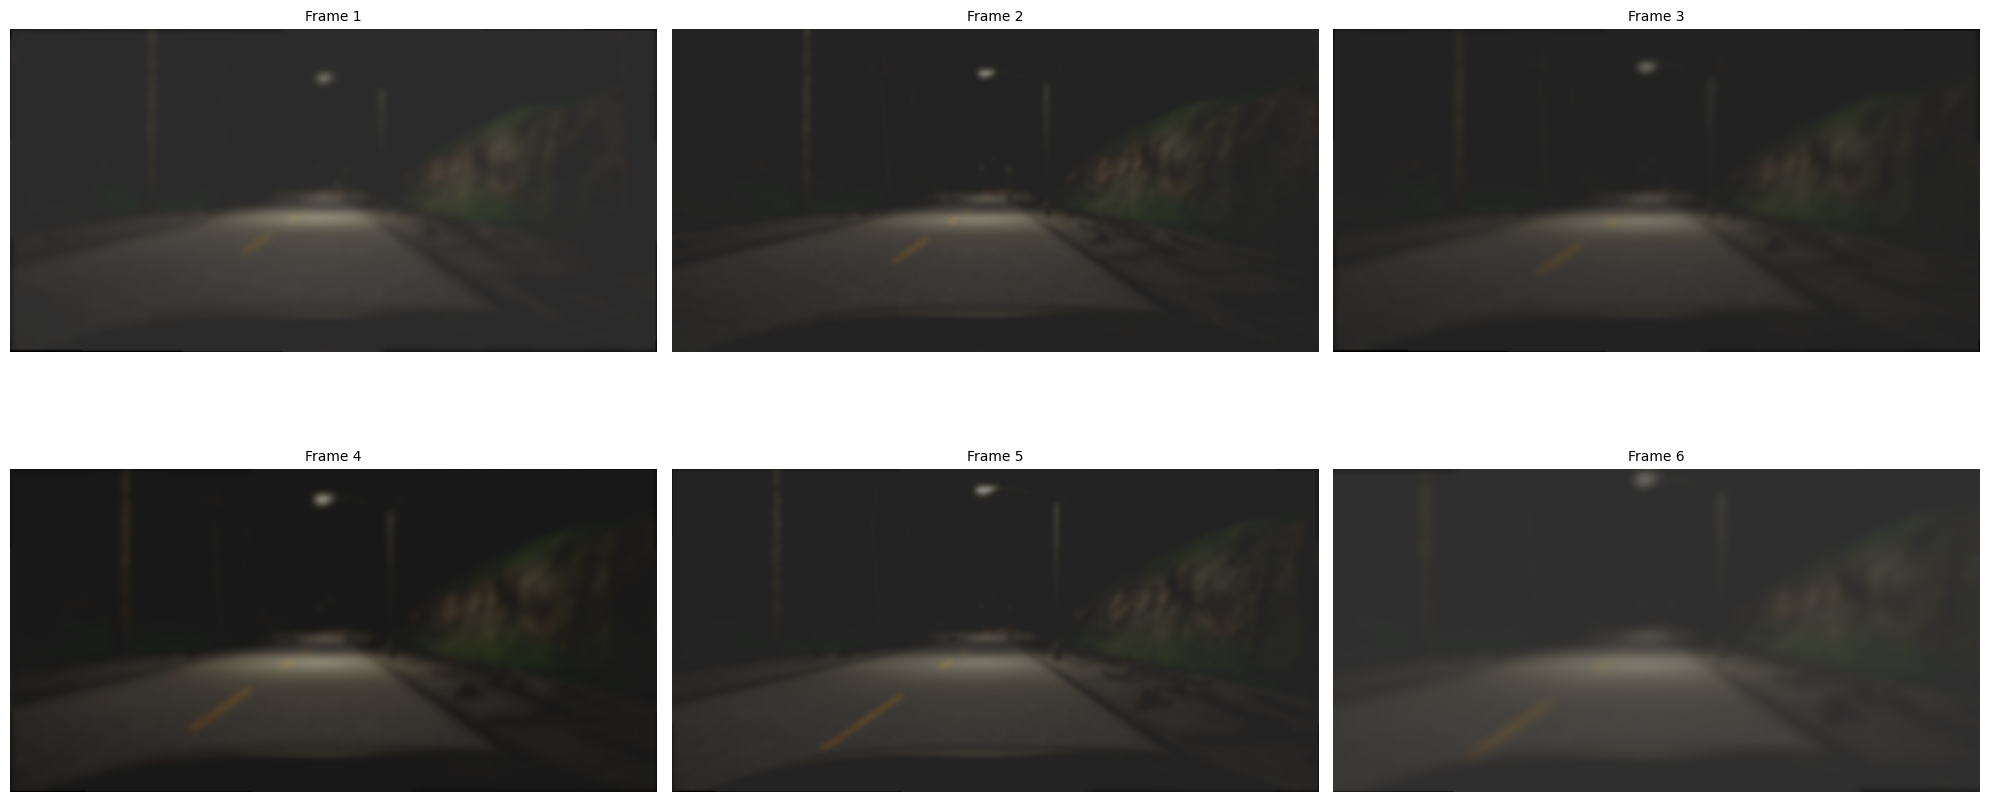

Base Carla Images


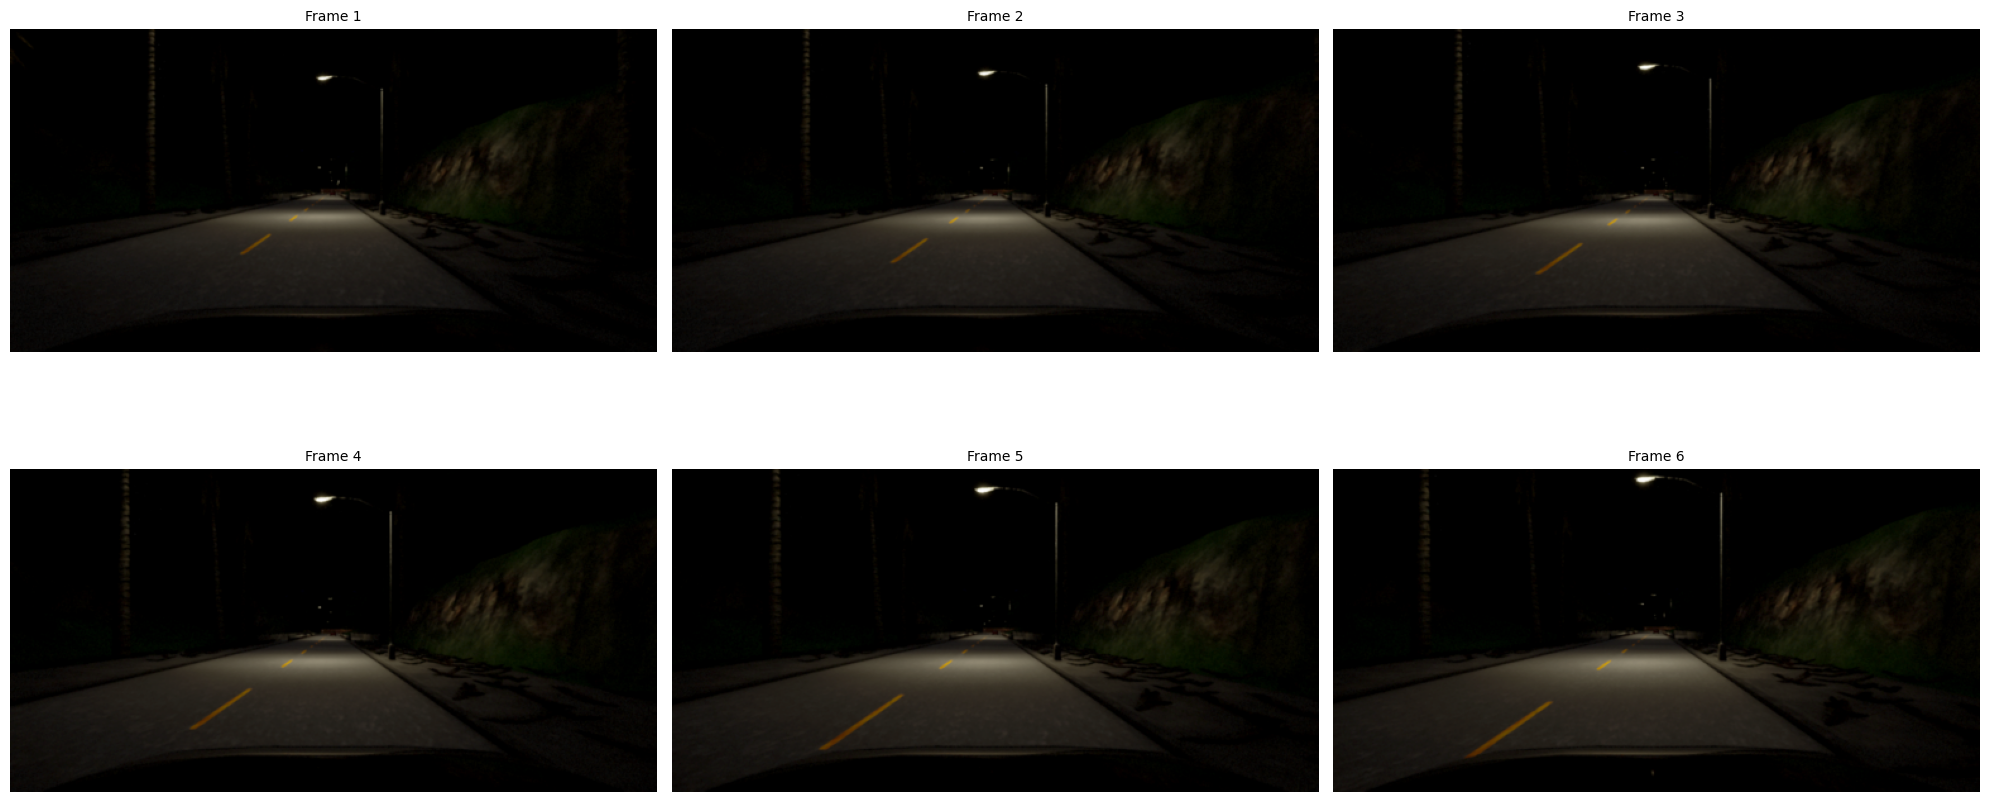

In [16]:

print("Corrupted Carla Images")
for org_batch_idx, (org_sequence_tensors, org_optical_flow, org_segmentation_tensors, org_extrinsics, org_depth_tensor) in enumerate(org_train_loader):
    if org_batch_idx == 1:  # Choose the second sequence by setting the index to 1, or any other index you wish to visualize
        org_first_sequence_tensor = org_sequence_tensors[0] 

        # Check if the tensor contains non-zero data
        if torch.any(org_first_sequence_tensor):
            # Now visualize this sequence
            visualize_sequence(org_first_sequence_tensor, rows=2, cols=3)
        else:
            print(f"The tensor for sequence at index {batch_idx} contains only zeros or is not loaded correctly.")

        break 
print("Base Carla Images")
for batch_idx, (sequence_tensors, optical_flow, segmentation_tensors, extrinsics, depth_tensor) in enumerate(train_loader):
    if batch_idx == 1:  # Choose the second sequence by setting the index to 1, or any other index you wish to visualize
        first_sequence_tensor = sequence_tensors[0] 

        # Check if the tensor contains non-zero data
        if torch.any(first_sequence_tensor):
            # Now visualize this sequence
            visualize_sequence(first_sequence_tensor, rows=2, cols=3)
        else:
            print(f"The tensor for sequence at index {batch_idx} contains only zeros or is not loaded correctly.")

        break  


In [17]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Model's Utilities

In [18]:
def decode_segmap(label_mask, n_classes=23):
    """
    Decode segmentation class labels into a color image.
    Args:
        label_mask (numpy.ndarray): an (M,N) array of integer values denoting
          the class label at each spatial location.
        n_classes (int): the number of classes in the dataset.
    Returns:
        (numpy.ndarray): the resulting decoded color image.
    """
    label_colors = np.array([
        (0, 0, 0),        # Unlabeled
        (70, 70, 70),     # Building
        (100, 40, 40),    # Fence
        (55, 90, 80),     # others
        (220, 20, 60),    # Pedestrian
        (153, 153, 153),  # Pole
        (157, 234, 50),   # RoadLine
        (128, 64, 128),   # Road
        (244, 35, 232),   # SideWalk
        (107, 142, 35),   # Vegetation
        (0, 0, 142),      # Vehicles
        (102, 102, 156),  # Wall
        (220, 220, 0),    # TrafficSign
        (70, 130, 180),   # Sky
        (81, 0, 81),      # Ground
        (150, 100, 100),  # Bridge
        (230, 150, 140),  # RailTrack
        (180, 165, 180),  # GuardRail
        (250, 170, 30),   # TrafficLight
        (110, 190, 160),  # Static
        (170, 120, 50),   # Dynamic
        (45, 60, 150),    # Water
        (145, 170, 100),  # Terrain
        (255, 255, 255),  # ignore_index=22
    ])

    r = np.zeros_like(label_mask).astype(np.uint8)
    g = np.zeros_like(label_mask).astype(np.uint8)
    b = np.zeros_like(label_mask).astype(np.uint8)

    for l in range(0, n_classes):
        idx = label_mask == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb


In [19]:
def calculate_mAcc(preds, targets):
    max_preds = preds.argmax(dim=1, keepdim=True)  
    correct_pred = max_preds.squeeze(1).eq(targets)
    acc_per_class = []

    for class_idx in range(targets.max() + 1):
        correct = correct_pred[targets == class_idx].sum()
        total = (targets == class_idx).sum()
        if total != 0:
            acc_per_class.append(correct.float() / total)

    mAcc = torch.mean(torch.stack(acc_per_class)) if acc_per_class else torch.tensor(0)
    return mAcc.item()


def calculate_mIoU(predicted_classes, target_classes, num_classes, device='cpu'):
    intersection = torch.zeros(num_classes, device=device)
    union = torch.zeros(num_classes, device=device)

    for class_idx in range(num_classes):
        intersection_mask = (predicted_classes == class_idx) & (target_classes == class_idx)
        union_mask = (predicted_classes == class_idx) | (target_classes == class_idx)
        
        intersection[class_idx] = intersection_mask.sum()
        union[class_idx] = union_mask.sum()

    # Avoid division by zero
    union[union == 0] = 1
    iou = intersection / union
    mIoU = iou.mean().item()
    return mIoU

In [20]:
def calculate_distances(poses):
    # Calculate distances between consecutive poses
    distances = torch.sqrt(torch.sum((poses[0, 1:, :3, 3] - poses[0, :-1, :3, 3]) ** 2, axis=1))
    return distances.cpu().detach().numpy()

def analyze_translations(original_poses, predicted_poses):
    # Compute statistics
    original_distances = calculate_distances(original_poses)
    predicted_distances = calculate_distances(predicted_poses)

    # Compute statistics
    statistics = {
        "original": {
            "mean_distance": np.mean(original_distances),
            "std_distance": np.std(original_distances),
            "max_distance": np.max(original_distances),
            "min_distance": np.min(original_distances),
        },
        "predicted": {
            "mean_distance": np.mean(predicted_distances),
            "std_distance": np.std(predicted_distances),
            "max_distance": np.max(predicted_distances),
            "min_distance": np.min(predicted_distances),
        }
    }
    return statistics

In [21]:
%run EncoderCNN.ipynb
%run ConvRNN.ipynb
%run Decoder.ipynb
%run MotionEncoder.ipynb
%run CameraEncoder.ipynb
%run RNN.ipynb
%run CameraDecoder.ipynb
%run DepthMap.ipynb

# Initializing All Components of Architecture

In [42]:
# Encoder
encoder = Encoder()
print(encoder)

# ConvLSTM parameters
input_channels = 64 
hidden_channels = 64  
kernel_size = 3  
stride = 1  
conv_lstm_model = ConvLSTM(in_channels=input_channels,
                           hidden_channels=hidden_channels,
                           kernel_size=kernel_size,
                           stride=stride,)
print(conv_lstm_model)

# Depth Decoder
depth_decoder = DepthDecoder(input_channels=64, depth_channels=1)
print(depth_decoder)

# Decoder Parameters:
num_classes =23
in_channels = 64
out_channels = 23
decoder = Decoder(in_channels, out_channels)
print(decoder)

# Motion Encoder
motion_in_channels = 66  
motion_hidden_channels = 64  
motion_kernel_size = 3  
motion_encoder = MotionEncoder(motion_in_channels, motion_hidden_channels, motion_kernel_size)
print(motion_encoder)

# Camera Encoder
camera_encoder = CameraEncoder(input_channels=64)
print(camera_encoder)

# RNN
hidden_size = 64  
output_size = 16  
ego_motion_rnn = EgoMotionRNN(hidden_size, output_size)
print(ego_motion_rnn)

# Camera Decoder
camera_decoder = CameraDecoder(input_size=16, hidden_size=36)
print(camera_decoder)

Encoder(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)
ConvLSTM(
  (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
DepthDecoder(
  (upsample1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (upsample2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (depth_conv): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
Decoder(
  (up1): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (

In [23]:
import torch.nn as nn

# Optimizer
optimizer = optim.Adam(list(encoder.parameters()) + list(conv_lstm_model.parameters()) + list(depth_decoder.parameters()) + list(decoder.parameters()) + list(motion_encoder.parameters()) + list(camera_encoder.parameters()) + list(ego_motion_rnn.parameters())+ list(camera_decoder.parameters()), lr=3e-4)

#Criterions
criterion = nn.CrossEntropyLoss(ignore_index=22)
Cam_criterion = nn.MSELoss()

def Depth_criterian(predicted, true):
    min_value = 1e-8
    predicted_clamped = torch.clamp(predicted, min=min_value)
    true_clamped = torch.clamp(true, min=min_value)
    log_predicted = torch.log(predicted_clamped)
    log_true = torch.log(true_clamped)
    loss = F.l1_loss(log_predicted, log_true)
    return loss

In [24]:
torch.cuda.empty_cache()

# Training Loop

In [25]:
class SegmentationModelTrainer:
    def __init__(self, encoder, conv_lstm, depth_decoder, decoder, motion_encoder, camera_encoder, ego_motion_rnn, camera_decoder, train_loader, val_loader, criterion, Cam_criterion, Depth_criterian, optimizer, device):
        self.encoder = encoder
        self.conv_lstm_model = conv_lstm
        self.depth_decoder = depth_decoder
        self.decoder = decoder
        self.motion_encoder = motion_encoder
        self.camera_encoder = camera_encoder
        self.ego_motion_rnn = ego_motion_rnn
        self.camera_decoder = camera_decoder
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.Cam_criterion = Cam_criterion
        self.Depth_criterian = Depth_criterian
        self.optimizer = optimizer
        self.device = device

        # Move models to the specified device
        self.encoder.to(device)
        self.conv_lstm_model.to(device)
        self.depth_decoder.to(device)
        self.decoder.to(device)
        self.motion_encoder.to(device)
        self.camera_encoder.to(device)
        self.ego_motion_rnn.to(device)
        self.camera_decoder.to(device)
        

    def train_epoch(self, epoch):
        self.encoder.train()
        self.conv_lstm_model.train()
        self.depth_decoder.train()
        self.decoder.train()
        self.motion_encoder.train()
        self.camera_encoder.train()
        self.ego_motion_rnn.train()
        self.camera_decoder.train()

        seg_losses = []
        depth_losses = []
        cam_losses = []
        total_losses = []
        previous_features = None
        
        for sequence_batch, optical_flow_batch, segmentation_targets, extrinsics, depth_tensor in tqdm(self.train_loader, desc="Training"):
            
            sequence_batch = sequence_batch.to(self.device)
            optical_flow_batch = optical_flow_batch.to(self.device)
            segmentation_targets = segmentation_targets.to(self.device)
            extrinsics = extrinsics.to(self.device)
            depth_tensor = depth_tensor.to(self.device)
            
            sequence_length = sequence_batch.size(1)
            batch_size = sequence_batch.size(0)
            
            depth_tensor = depth_tensor[0, :, :, :, :]
            
            # Process segmentation targets as needed before using them as model inputs
            segmentation_targets = self._process_segmentation_targets(segmentation_targets)

            self.optimizer.zero_grad()
            
            encoder_outputs = []
            motion_features_list = []

            for t in range(sequence_length):
                img_t = sequence_batch[:, t, :, :, :] 
                optical_flow_t = optical_flow_batch[:, t, :, :, :] 
                # ENCODER
                encoder_output_t = self.encoder(img_t)  
                encoder_outputs.append(encoder_output_t)

                # MOTION ENCODER
                motion_features_t = self.motion_encoder(encoder_output_t, optical_flow_t)
                motion_features_list.append(motion_features_t)
                

            # After processing all time steps, stack the outputs
            encoder_output = torch.stack(encoder_outputs, dim=1)
            motion_encoder = torch.stack(motion_features_list, dim=1)
            
            # Camera Encoder
            motion_encoder = motion_encoder[0, :, :, :, :]
            camera_encoder_output_t = self.camera_encoder(motion_encoder)
            
            # RNN
            # Doing dimentionality reduction 
            camera_encoder_output_t = camera_encoder_output_t.mean(dim=0, keepdim=True)
            camera_encoder_output_flat = camera_encoder_output_t.view(batch_size, sequence_length, -1)  
            extrinsics_flat = extrinsics.view(batch_size, sequence_length, -1) 
            combined_input = torch.cat((camera_encoder_output_flat, extrinsics_flat), dim=2)  
            ego_motion_output = self.ego_motion_rnn(combined_input)

            # CAMERA DECODER
            ego_motion_output = ego_motion_output[:, -1, :]
            camera_poses = self.camera_decoder(ego_motion_output)
            
            # Calculate the scaling factor based on the means of the original and predicted distances
            stats = analyze_translations(extrinsics, camera_poses)
            scaling_factor = stats['original']['mean_distance'] / stats['predicted']['mean_distance']

            # Apply the scaling factor to the translations of the predicted camera poses
            camera_poses_scaled = camera_poses.clone() 
            camera_poses_scaled[:, :, :3, 3] *= scaling_factor
            
            # Hidden Layer_org
            batch_size, seq_length, channels, height, width = encoder_output.size()
            hidden_state, cell_state = self.conv_lstm_model.init_hidden(batch_size, height, width)
            
            # ConvLSTM
            conv_lstm_output, (hidden_state, cell_state) = self.conv_lstm_model(encoder_output, (hidden_state.to(self.device), cell_state.to(self.device)))
            batch_size, seq_length, channels, height, width = conv_lstm_output.size()
            conv_lstm_output = conv_lstm_output.view(batch_size * seq_length, channels, height, width)
            
            # DEPTH DECODER
            depth_decoder_output = self.depth_decoder(conv_lstm_output)
            
            # Decoder
            decoder_output = self.decoder(conv_lstm_output)
            
            # Backpropagation for Segmentation Loss
            seg_loss = self.criterion(decoder_output, segmentation_targets)
            seg_losses.append(seg_loss.item())

            # Backpropagation for Depth Loss
            depth_loss = self.Depth_criterian(depth_decoder_output, depth_tensor)
            depth_losses.append(depth_loss.item())

            # Backpropagation for Camera Pose Loss
            cam_loss = self.Cam_criterion(camera_poses_scaled, extrinsics)
            cam_losses.append(cam_loss.item())
            
            # Total Losses
            total_loss = seg_loss + depth_loss + cam_loss
            self.optimizer.zero_grad()           
            total_loss.backward()
            self.optimizer.step()
            total_losses.append(total_loss.item())
            
            #writer.add_scalar('Loss/Train/Segmentation', seg_loss.item(), global_step=epoch * len(self.train_loader) + batch_idx)
            #writer.add_scalar('Loss/Train/Depth', depth_loss.item(), global_step=epoch * len(self.train_loader) + batch_idx)
            #writer.add_scalar('Loss/Train/Camera', cam_loss.item(), global_step=epoch * len(self.train_loader) + batch_idx)

        # Save all models here
        model_save_path = 'Models/BaseCARLA'  
        if not os.path.exists(model_save_path):
            os.makedirs(model_save_path)

        torch.save(self.encoder.state_dict(), os.path.join(model_save_path, f'Encoder.pth'))
        torch.save(self.conv_lstm_model.state_dict(), os.path.join(model_save_path, f'ConvLSTM.pth'))
        torch.save(self.depth_decoder.state_dict(), os.path.join(model_save_path, f'DepthDecoder.pth'))
        torch.save(self.decoder.state_dict(), os.path.join(model_save_path, f'SegmentationDecoder.pth'))
        torch.save(self.motion_encoder.state_dict(), os.path.join(model_save_path, f'MotionEncoder.pth'))
        torch.save(self.camera_encoder.state_dict(), os.path.join(model_save_path, f'CameraEncoder.pth'))
        torch.save(self.ego_motion_rnn.state_dict(), os.path.join(model_save_path, f'EgoMotionRNN.pth'))
        torch.save(self.camera_decoder.state_dict(), os.path.join(model_save_path, f'CameraDecoder.pth'))
        
        # converting lists to tensors to calculate means
        seg_losses_tensor = torch.tensor(seg_losses)
        depth_losses_tensor = torch.tensor(depth_losses)
        cam_losses_tensor = torch.tensor(cam_losses)
        total_losses_tensor = torch.tensor(total_losses)

        # Calculating means
        mean_seg_loss = torch.mean(seg_losses_tensor).item()
        mean_depth_loss = torch.mean(depth_losses_tensor).item()
        mean_cam_loss = torch.mean(cam_losses_tensor).item()
        mean_total_loss = torch.mean(total_losses_tensor).item()
        
        return mean_seg_loss, mean_depth_loss, mean_cam_loss, mean_total_loss

        
    @torch.no_grad()
    def validate_epoch(self, epoch):
        self.encoder.eval()
        self.conv_lstm_model.eval()
        self.depth_decoder.eval()
        self.decoder.eval()
        self.motion_encoder.eval()
        self.camera_encoder.eval()
        self.ego_motion_rnn.eval()
        self.camera_decoder.eval()

        seg_val_losses = []
        cam_val_losses = []
        depth_val_losses = []
        val_total_losses = []
        mAccs = []
        val_mIoUs = []
        previous_features = None
        
        for val_sequence_batch, val_optical_flow_batch, val_segmentation_targets, val_extrinsics, val_depth_tensor in tqdm(self.val_loader, desc="Validation"):
            
            val_sequence_batch = val_sequence_batch.to(self.device)
            val_segmentation_targets = val_segmentation_targets.to(self.device)
            val_optical_flow_batch = val_optical_flow_batch.to(self.device)
            val_extrinsics = val_extrinsics.to(self.device)
            val_depth_tensor = val_depth_tensor.to(self.device)

            # Flatten the sequence and batch dimensions
            sequence_length = val_sequence_batch.size(1)
            batch_size = val_sequence_batch.size(0)
            val_depth_tensor = val_depth_tensor[0, :, :, :, :]
            
            # Process segmentation targets as needed before using them as model inputs
            val_segmentation_targets = self._process_segmentation_targets(val_segmentation_targets)
                  
            encoder_outputs = []
            motion_features_list = []
            
            for t in range(sequence_length):
                img_t = val_sequence_batch[:, t, :, :, :] 
                optical_flow_t = val_optical_flow_batch[:, t, :, :, :] 
                # ENCODER
                encoder_output_t = self.encoder(img_t)  
                encoder_outputs.append(encoder_output_t)

                # MOTION ENCODER
                motion_features_t = self.motion_encoder(encoder_output_t, optical_flow_t)
                motion_features_list.append(motion_features_t)
                

            # After processing all time steps, stack the outputs
            encoder_output = torch.stack(encoder_outputs, dim=1)
            motion_encoder = torch.stack(motion_features_list, dim=1)
            
            # Camera Encoder
            motion_encoder = motion_encoder[0, :, :, :, :]
            camera_encoder_output_t = self.camera_encoder(motion_encoder)
            
            # RNN
            # Doing dimentionality reduction 
            camera_encoder_output_t = camera_encoder_output_t.mean(dim=0, keepdim=True)
            camera_encoder_output_flat = camera_encoder_output_t.view(batch_size, sequence_length, -1)  
            extrinsics_flat = val_extrinsics.view(batch_size, sequence_length, -1) 
            combined_input = torch.cat((camera_encoder_output_flat, extrinsics_flat), dim=2)  
            ego_motion_output = self.ego_motion_rnn(combined_input)
            

            # CAMERA DECODER
            ego_motion_output = ego_motion_output[:, -1, :]
            camera_poses = self.camera_decoder(ego_motion_output)
            #camera_poses = camera_poses.view(-1, 4, 4)
            
            # Calculate the scaling factor based on the means of the original and predicted distances
            stats = analyze_translations(val_extrinsics, camera_poses)
            scaling_factor = stats['original']['mean_distance'] / stats['predicted']['mean_distance']

            # Apply the scaling factor to the translations of the predicted camera poses
            camera_poses_scaled = camera_poses.clone() 
            camera_poses_scaled[:, :, :3, 3] *= scaling_factor
            
            # Hidden Layer_org
            batch_size, seq_length, channels, height, width = encoder_output.size()
            hidden_state, cell_state = self.conv_lstm_model.init_hidden(batch_size, height, width)

            # ConvLSTM
            conv_lstm_output, (hidden_state, cell_state) = self.conv_lstm_model(encoder_output, (hidden_state.to(self.device), cell_state.to(self.device)))
            batch_size, seq_length, channels, height, width = conv_lstm_output.size()
            conv_lstm_output = conv_lstm_output.view(batch_size * seq_length, channels, height, width)

            # DEPTH DECODER
            depth_decoder_output = self.depth_decoder(conv_lstm_output)
            
            # Decoder
            decoder_output = self.decoder(conv_lstm_output)
            
            mAcc = calculate_mAcc(decoder_output, val_segmentation_targets)
            mAccs.append(mAcc)
            
            predicted_classes = torch.argmax(decoder_output, dim=1)
            mIoU = calculate_mIoU(predicted_classes, val_segmentation_targets, num_classes, self.device)
            val_mIoUs.append(mIoU)

            seg_val_loss = self.criterion(decoder_output, val_segmentation_targets)
            seg_val_losses.append(seg_val_loss.item())

            depth_val_loss = self.Depth_criterian(depth_decoder_output, val_depth_tensor)
            depth_val_losses.append(depth_val_loss.item())

            cam_val_loss = self.Cam_criterion(camera_poses_scaled, val_extrinsics)
            cam_val_losses.append(cam_val_loss.item())
            
            val_total_loss = seg_val_loss + depth_val_loss + cam_val_loss
            val_total_losses.append(val_total_loss.item())
            
        # After the loop, convert lists to tensors to calculate means
        seg_val_losses_tensor = torch.tensor(seg_val_losses)
        depth_val_losses_tensor = torch.tensor(depth_val_losses)
        cam_val_losses_tensor = torch.tensor(cam_val_losses)
        mAccs_tensor = torch.tensor(mAccs)
        val_mIoUs_tensor = torch.tensor(val_mIoUs)
        val_total_losses_tensor = torch.tensor(val_total_losses)

        # Calculate means
        mean_seg_val_loss = torch.mean(seg_val_losses_tensor).item()
        mean_depth_val_loss = torch.mean(depth_val_losses_tensor).item()
        mean_cam_val_loss = torch.mean(cam_val_losses_tensor).item()
        mean_mAcc = torch.mean(mAccs_tensor).item()
        mean_val_mIoU = torch.mean(val_mIoUs_tensor).item()
        mean_val_total_loss = torch.mean(val_total_losses_tensor).item()
        
        return mean_seg_val_loss, mean_depth_val_loss, mean_cam_val_loss, mean_mAcc, mean_val_mIoU, mean_val_total_loss

    def fit(self, epochs):
        for epoch in range(epochs):
            
            print(f"Epoch {epoch+1}/{epochs}")
            mean_seg_losses, mean_depth_losses, mean_cam_losses, mean_total_loss= self.train_epoch(epochs)
            seg_loss_list.append(mean_seg_losses)
            depth_loss_list.append(mean_depth_losses)
            cam_loss_list.append(mean_cam_losses)
            total_loss_list.append(mean_total_loss)
            
            #print(f"Epoch {epoch} - Segmentation Loss: {mean_seg_losses}, Depth Loss: {mean_depth_losses}, Camera Pose Loss: {mean_cam_losses}")
            mean_seg_val_loss, mean_depth_val_loss, mean_cam_val_loss, mean_mAcc, mean_val_mIoU, mean_val_total_loss= trainer.validate_epoch(epochs)
            
            seg_val_loss_list.append(mean_seg_val_loss)
            depth_val_loss_list.append(mean_depth_val_loss)
            cam_val_loss_list.append(mean_cam_val_loss)
            mAcc_list.append(mean_mAcc)
            val_mIoU_list.append(mean_val_mIoU)
            val_total_loss_list.append(mean_val_total_loss)
            
            print(f"Epoch {epoch} - Val Segmentation Loss: {mean_seg_val_loss}, Val Depth Loss: {mean_depth_val_loss}, Val Camera Pose Loss: {mean_cam_val_loss}")
            print(f"Epoch {epoch} - Val mAcc: {mean_mAcc}, Val mIoU: {mean_val_mIoU}")
        
        

    def _process_segmentation_targets(self, segmentation_targets):
        # Preprocessing on segmentation_targets
      
        if segmentation_targets.size()[-1] == 3:
            batch_size, seq_len, _, height, width = segmentation_targets.size()
            segmentation_targets= segmentation_targets[0, :, :, :, 0]
            segmentation_targets = segmentation_targets.long()
                
        elif segmentation_targets.dim() == 4:
            segmentation_targets= segmentation_targets[0, :, :, :]

        else:
            batch_size, seq_len, _, height, width = segmentation_targets.size()
            segmentation_targets= segmentation_targets[0, :, 0, :, :]
            segmentation_targets = segmentation_targets.long()
        return segmentation_targets


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

# Initialize the Trainer
trainer = SegmentationModelTrainer(encoder, conv_lstm_model, depth_decoder, decoder, motion_encoder, camera_encoder, ego_motion_rnn, camera_decoder, train_loader, val_loader, criterion, Cam_criterion, Depth_criterian, optimizer, device)

# Train the model
val_mIoU_list = []
mAcc_list = []
seg_loss_list, depth_loss_list, cam_loss_list, total_loss_list = [], [], [], []
seg_val_loss_list, depth_val_loss_list, cam_val_loss_list, val_total_loss_list= [], [], [], []
epochs=5
trainer.fit(epochs)
writer.close() 

Epoch 1/5


Validation: 100%|███████████████████████████████████████████████████████████████████| 1497/1497 [25:08<00:00,  1.01s/it]


Epoch 0 - Val Segmentation Loss: 2.309443712234497, Val Depth Loss: 17.63500213623047, Val Camera Pose Loss: 3514.765625
Epoch 0 - Val mAcc: 0.11580894142389297, Val mIoU: 0.05871982127428055
Epoch 2/5


Validation: 100%|███████████████████████████████████████████████████████████████████| 1497/1497 [19:29<00:00,  1.28it/s]


Epoch 1 - Val Segmentation Loss: 2.027698516845703, Val Depth Loss: 0.40556392073631287, Val Camera Pose Loss: 3731.859619140625
Epoch 1 - Val mAcc: 0.12786030769348145, Val mIoU: 0.07034921646118164
Epoch 3/5


Validation: 100%|███████████████████████████████████████████████████████████████████| 1497/1497 [21:18<00:00,  1.17it/s]


Epoch 2 - Val Segmentation Loss: 2.032072067260742, Val Depth Loss: 0.3734437823295593, Val Camera Pose Loss: 2372.5029296875
Epoch 2 - Val mAcc: 0.13229341804981232, Val mIoU: 0.07438379526138306
Epoch 4/5


Validation: 100%|███████████████████████████████████████████████████████████████████| 1497/1497 [20:42<00:00,  1.20it/s]


Epoch 3 - Val Segmentation Loss: 1.9531418085098267, Val Depth Loss: 0.3673743009567261, Val Camera Pose Loss: 2518.62939453125
Epoch 3 - Val mAcc: 0.13382981717586517, Val mIoU: 0.07588988542556763
Epoch 5/5


Validation: 100%|███████████████████████████████████████████████████████████████████| 1497/1497 [28:54<00:00,  1.16s/it]


Epoch 4 - Val Segmentation Loss: 2.0047407150268555, Val Depth Loss: 0.35936471819877625, Val Camera Pose Loss: 4298.54931640625
Epoch 4 - Val mAcc: 0.14035050570964813, Val mIoU: 0.08064104616641998


NameError: name 'writer' is not defined

# Visualising Accuracies and Losses

In [ ]:
# Aggregating your training and validation statistics
training_stats = {
    "seg_loss_list": seg_loss_list,
    "depth_loss_list": depth_loss_list,
    "cam_loss_list": cam_loss_list,
    "total_loss_list": total_loss_list,
    "seg_val_loss_list": seg_val_loss_list,
    "depth_val_loss_list": depth_val_loss_list,
    "cam_val_loss_list": cam_val_loss_list,
    "val_total_loss_list": val_total_loss_list,
    "mAcc_list": mAcc_list,
    "val_mIoU_list": val_mIoU_list,
     }

# Saving the statistics to a JSON file
with open('Models/BaseCARLA/training_stats.json', 'w') as f:
    json.dump(training_stats, f, indent=4)

print("Training statistics saved to 'Models/BaseCARLA/training_stats.json'.")

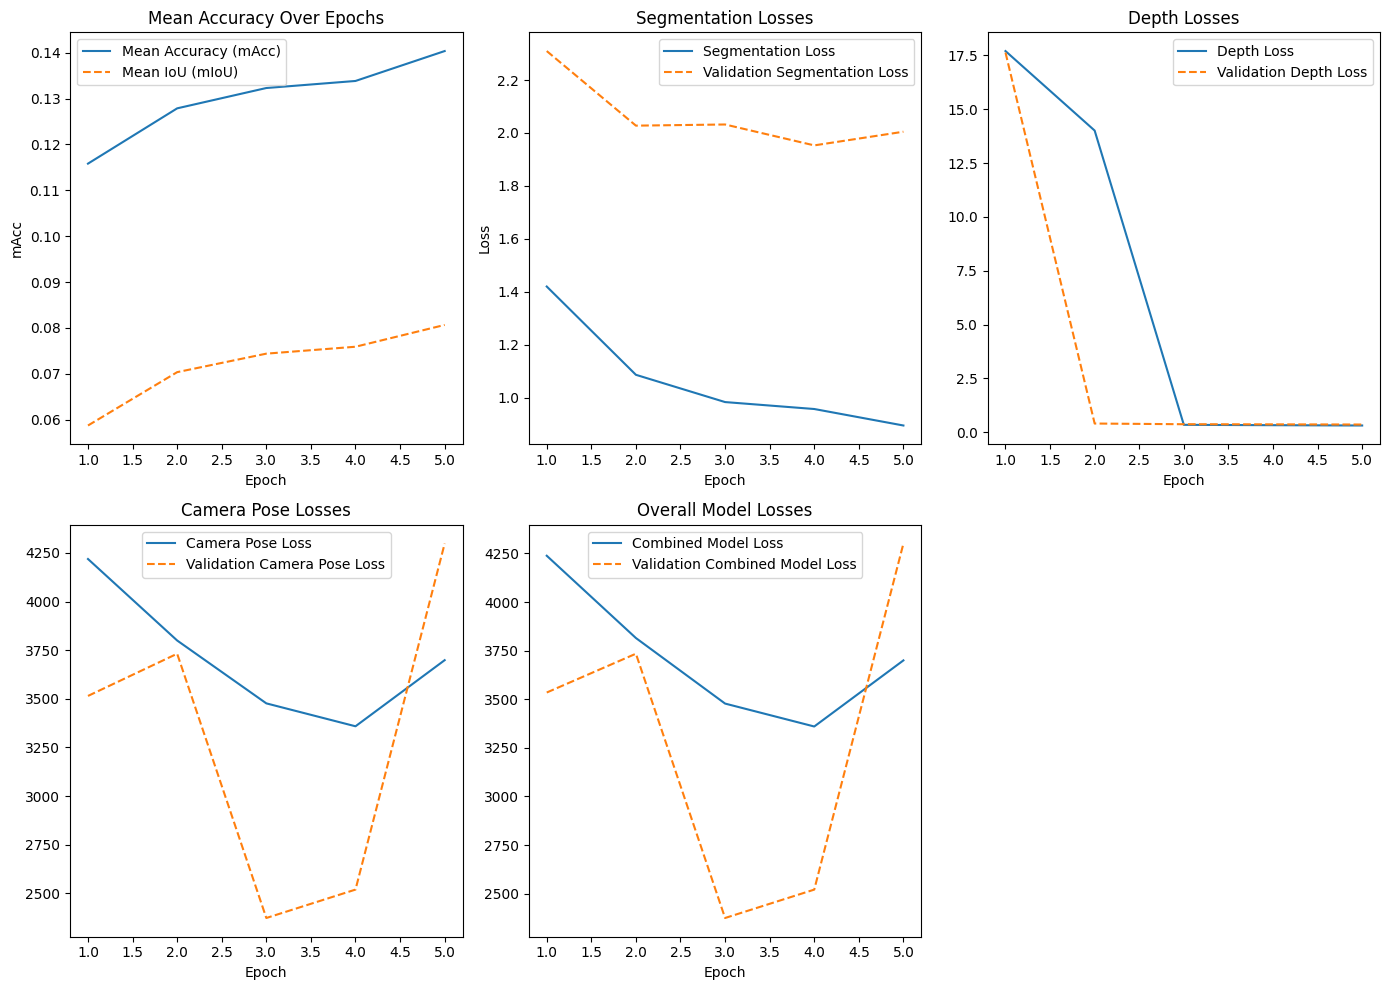

In [3]:
import json

with open('Models/BaseCARLA/training_stats.json', 'r') as f:
    training_stats = json.load(f)
epochs = range(1, len(training_stats['seg_loss_list']) + 1)


plt.figure(figsize=(14, 10))

# Mean Accuracy (mAcc)
plt.subplot(2, 3, 1)
plt.plot(epochs, training_stats['mAcc_list'], label='Mean Accuracy (mAcc)')
plt.plot(epochs, training_stats['val_mIoU_list'], label='Mean IoU (mIoU)', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('mAcc')
plt.title('Mean Accuracy Over Epochs')
plt.legend()


# Segmentation Losses
#plt.figure(figsize=(14, 10))
plt.subplot(2, 3, 2)
plt.plot(epochs, training_stats['seg_loss_list'], label='Segmentation Loss')
plt.plot(epochs, training_stats['seg_val_loss_list'], label='Validation Segmentation Loss', linestyle='--')
plt.title('Segmentation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Depth Losses
plt.subplot(2, 3, 3)
plt.plot(epochs, training_stats['depth_loss_list'], label='Depth Loss')
plt.plot(epochs, training_stats['depth_val_loss_list'], label='Validation Depth Loss', linestyle='--')
plt.title('Depth Losses')
plt.xlabel('Epoch')
plt.legend()

# Camera Pose Losses
plt.subplot(2, 3, 4)
plt.plot(epochs, training_stats['cam_loss_list'], label='Camera Pose Loss')
plt.plot(epochs, training_stats['cam_val_loss_list'], label='Validation Camera Pose Loss', linestyle='--')
plt.title('Camera Pose Losses')
plt.xlabel('Epoch')
plt.legend()

# Combined Model Losses
plt.subplot(2, 3, 5)
plt.plot(epochs, training_stats['total_loss_list'], label='Combined Model Loss')
plt.plot(epochs, training_stats['val_total_loss_list'], label='Validation Combined Model Loss', linestyle='--')
plt.title('Overall Model Losses')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Reloading Saved Models and Visualising Results

In [43]:
model_load_path = 'Models/BaseCARLA'
encoder.load_state_dict(torch.load(os.path.join(model_load_path, 'Encoder.pth'), map_location=device))
conv_lstm_model.load_state_dict(torch.load(os.path.join(model_load_path, 'ConvLSTM.pth'), map_location=device))
depth_decoder.load_state_dict(torch.load(os.path.join(model_load_path, 'DepthDecoder.pth'), map_location=device))
decoder.load_state_dict(torch.load(os.path.join(model_load_path, 'SegmentationDecoder.pth'), map_location=device))
motion_encoder.load_state_dict(torch.load(os.path.join(model_load_path, 'MotionEncoder.pth'), map_location=device))
camera_encoder.load_state_dict(torch.load(os.path.join(model_load_path, 'CameraEncoder.pth'), map_location=device))
ego_motion_rnn.load_state_dict(torch.load(os.path.join(model_load_path, 'EgoMotionRNN.pth'), map_location=device))
camera_decoder.load_state_dict(torch.load(os.path.join(model_load_path, 'CameraDecoder.pth'), map_location=device))


<All keys matched successfully>

In [44]:
# Function show all frames 
def visualize_sequence_full(sequence_batch, segmentation_targets, predicted_segmentation, depth_tensor, predicted_depth, device):
    batch_size, sequence_length, c, h, w = sequence_batch.size()

    for i in range(sequence_length):
        fig, axes = plt.subplots(1, 5, figsize=(25, 5))
        
        # Input image
        axes[0].imshow(sequence_batch[0, i].permute(1, 2, 0).cpu().numpy())
        axes[0].set_title('Input Image')

        # Ground truth segmentation
        gt_segmap = decode_segmap(segmentation_targets[0, i].cpu().numpy())
        axes[1].imshow(gt_segmap)
        axes[1].set_title('Ground Truth Segmentation')

        # Predicted segmentation
        pred_segmap = decode_segmap(predicted_segmentation[i].cpu().numpy())
        axes[2].imshow(pred_segmap)
        axes[2].set_title('Predicted Segmentation')

        # Ground truth depth map
        axes[3].imshow(depth_tensor[0, i].squeeze().cpu().numpy(), cmap='gray')
        axes[3].set_title('Ground Truth Depth Map')

        # Predicted depth map
        axes[4].imshow(predicted_depth[0, i].squeeze().cpu().detach().numpy(), cmap='gray')
        axes[4].set_title('Predicted Depth Map')

        plt.show()


In [45]:
# After loading all the models
encoder.eval()
conv_lstm_model.eval()
depth_decoder.eval()
decoder.eval()
motion_encoder.eval()
camera_encoder.eval()
ego_motion_rnn.eval()
camera_decoder.eval()


CameraDecoder(
  (fc1): Linear(in_features=16, out_features=36, bias=True)
  (fc2): Linear(in_features=36, out_features=96, bias=True)
  (relu): ReLU()
)

In [46]:
import imageio
import numpy as np
import torch
import os

# Make sure the save_gif function converts images to uint8
def save_gif(image_sequence, filename, duration=10):
    with imageio.get_writer(filename, mode='I', duration=duration, loop=0) as writer:
        for image in image_sequence:
            # Convert to uint8 if not already
            if image.dtype != np.uint8:
                # Assume the image data is in float and scale accordingly
                image = (255.0 * image).astype(np.uint8)
            writer.append_data(image)

In [47]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_camera_trajectories(original_poses, predicted_poses):
    # Extract the translation components from original and predicted poses
    original_translations = original_poses[0, :, :3, 3].cpu().detach().numpy()
    predicted_translations = predicted_poses[0, :, :3, 3].cpu().detach().numpy()

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the original trajectory
    ax.plot(original_translations[:, 0], original_translations[:, 1], original_translations[:, 2], 
            marker='o', color='red', label='Original Poses')

    # Plot the predicted trajectory
    ax.plot(predicted_translations[:, 0], predicted_translations[:, 1], predicted_translations[:, 2], 
            marker='^', color='blue', label='Predicted Poses')

    # Label each pose in the original trajectory
    for i, t in enumerate(original_translations):
        ax.text(t[0], t[1], t[2], f'O{i}', color='red')

    # Label each pose in the predicted trajectory
    for i, t in enumerate(predicted_translations):
        ax.text(t[0], t[1], t[2], f'P{i}', color='blue')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Camera Pose Trajectories')
    ax.legend()

    plt.show()

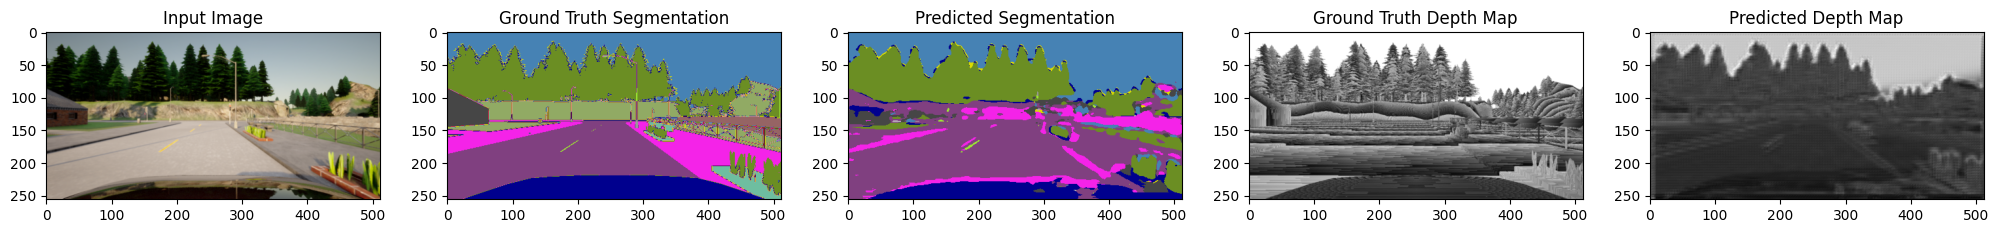

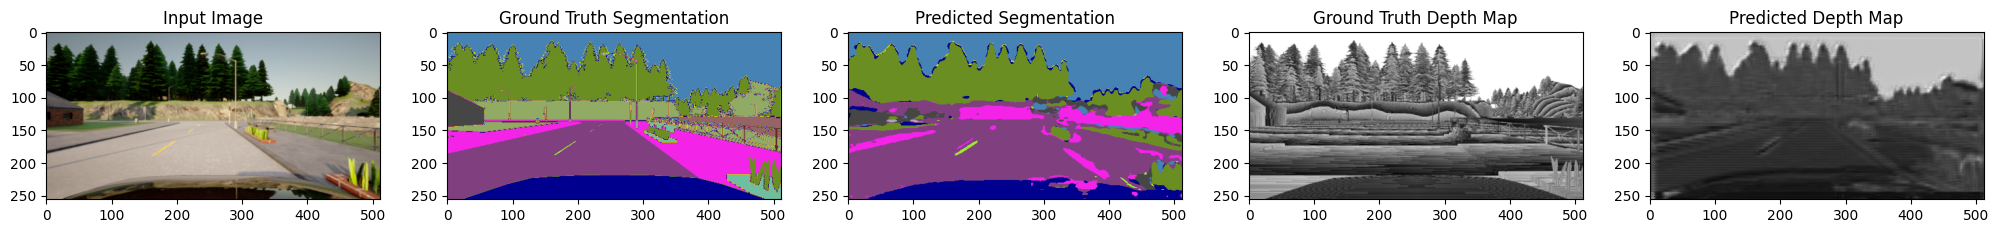

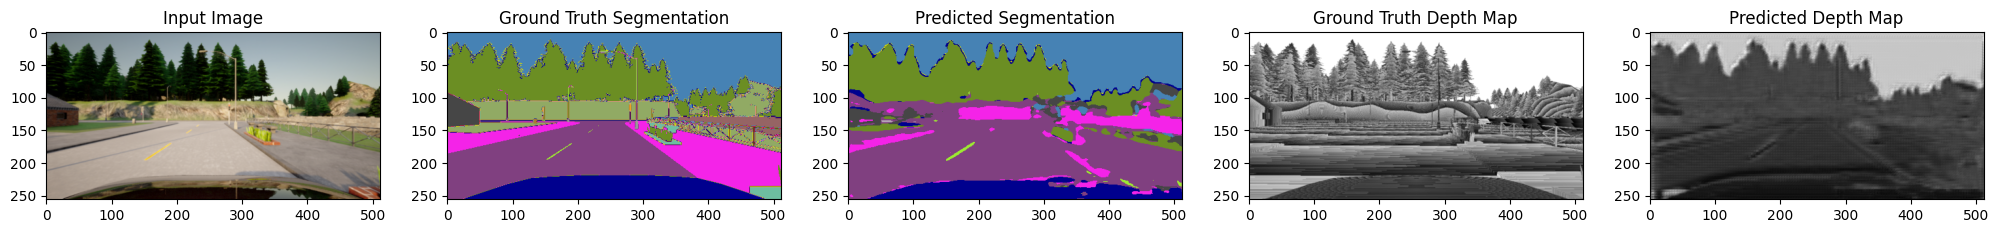

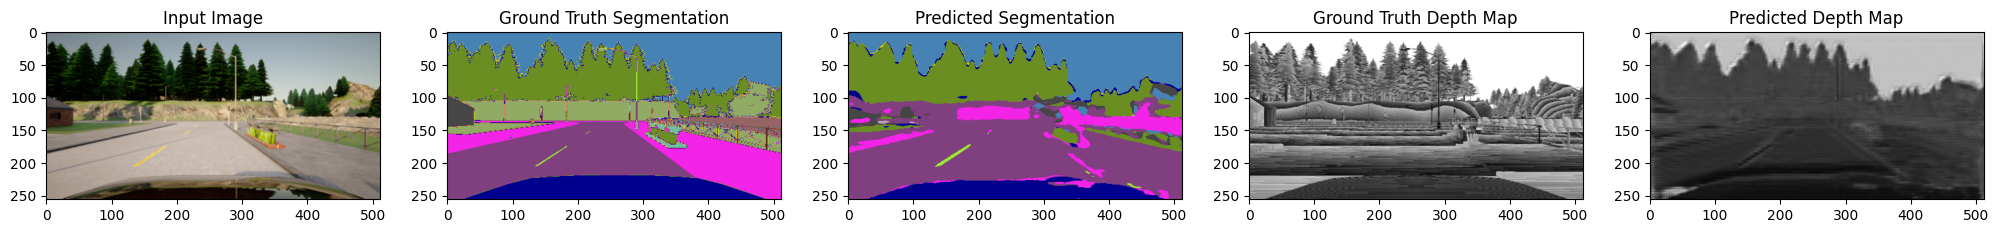

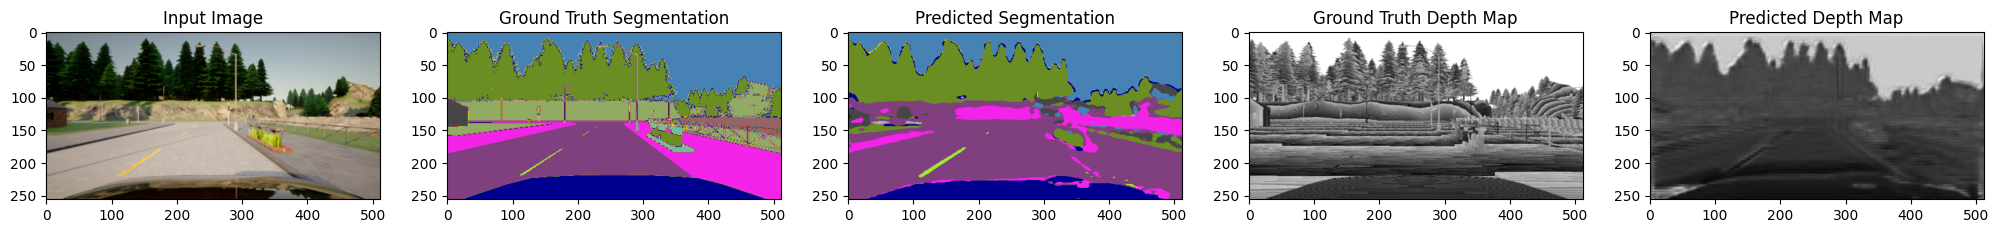

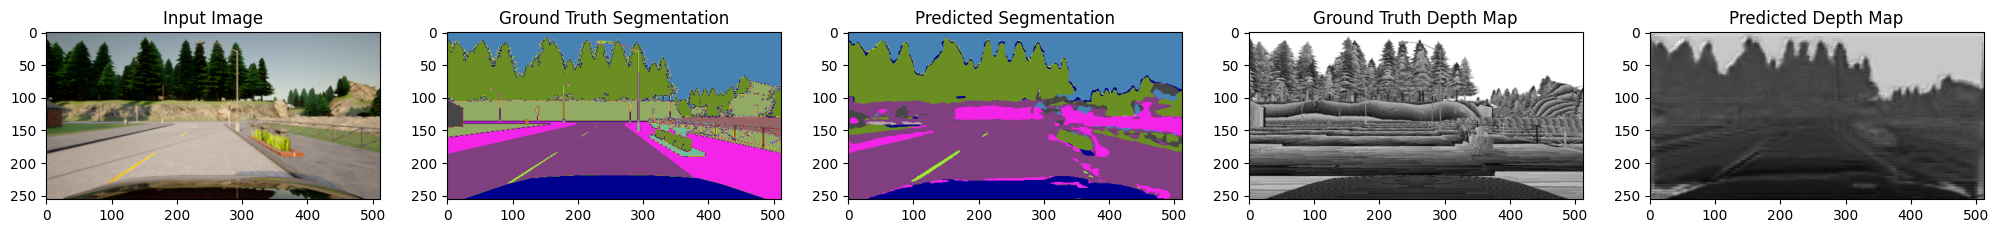

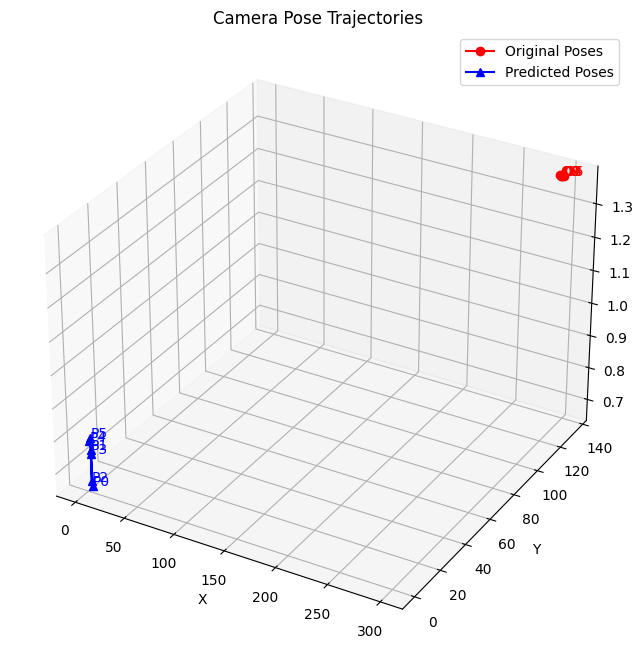

In [49]:
device = torch.device('cpu')

GIF_path = "GIF/BaseCARLA"
    
def _process_segmentation_targets(segmentation_targets):
    # Preprocessing on segmentation_targets
      
    if segmentation_targets.size()[-1] == 3:
        batch_size, seq_len, _, height, width = segmentation_targets.size()
        segmentation_targets= segmentation_targets[0, :, :, :, 0]
        segmentation_targets = segmentation_targets.long()
                
    elif segmentation_targets.dim() == 4:
        segmentation_targets= segmentation_targets[0, :, :, :]

    else:
        batch_size, seq_len, _, height, width = segmentation_targets.size()
        segmentation_targets= segmentation_targets[0, :, 0, :, :]
        # Convert segmentation_targets to Long type
        segmentation_targets = segmentation_targets.long()
    return segmentation_targets


for batch in val_loader: 
    # Move batch to device
    sequence_batch, optical_flow_batch, segmentation_targets, extrinsics, depth_tensor = [item.to(device) for item in batch]
    seg_targ = segmentation_targets
    sequence_batch = sequence_batch
    dep_targ = depth_tensor
    optical_flow_batch = optical_flow_batch
    segmentation_targets = segmentation_targets
    extrinsics = extrinsics
    depth_tensor = depth_tensor
    
        
    sequence_length = sequence_batch.size(1)
    batch_size = sequence_batch.size(0)
            
    depth_tensor = depth_tensor[0, :, :, :, :]
            
    # Process segmentation targets as needed before using them as model inputs
    segmentation_targets = _process_segmentation_targets(segmentation_targets)

    optimizer.zero_grad()
            
    encoder_outputs = []
    motion_features_list = []

    for t in range(sequence_length):
        img_t = sequence_batch[:, t, :, :, :] 
        optical_flow_t = optical_flow_batch[:, t, :, :, :] 
        # ENCODER
        encoder_output_t = encoder(img_t)  
        encoder_outputs.append(encoder_output_t)

        # MOTION ENCODER
        motion_features_t = motion_encoder(encoder_output_t, optical_flow_t)
        motion_features_list.append(motion_features_t)
                

    # After processing all time steps, stack the outputs
    encoder_output = torch.stack(encoder_outputs, dim=1)
    motion_encoderr = torch.stack(motion_features_list, dim=1)
            
    # Camera Encoder
    motion_encoderr = motion_encoderr[0, :, :, :, :]
    camera_encoder_output_t = camera_encoder(motion_encoderr)
            
    # RNN
    # Doing dimentionality reduction 
    camera_encoder_output_t = camera_encoder_output_t.mean(dim=0, keepdim=True)
    camera_encoder_output_flat = camera_encoder_output_t.view(batch_size, sequence_length, -1)  
    extrinsics_flat = extrinsics.view(batch_size, sequence_length, -1) 
    combined_input = torch.cat((camera_encoder_output_flat, extrinsics_flat), dim=2)  
    ego_motion_output = ego_motion_rnn(combined_input)

    # CAMERA DECODER
    ego_motion_output = ego_motion_output[:, -1, :]
    camera_poses = camera_decoder(ego_motion_output)
    
    # Calculate the scaling factor based on the means of the original and predicted distances
    stats = analyze_translations(extrinsics, camera_poses)
    scaling_factor = stats['original']['mean_distance'] / stats['predicted']['mean_distance']

    # Apply the scaling factor to the translations of the predicted camera poses
    camera_poses_scaled = camera_poses.clone()  # Clone to avoid modifying the original poses
    camera_poses_scaled[:, :, :3, 3] *= scaling_factor
            
    # Hidden Layer_org
    batch_size, seq_length, channels, height, width = encoder_output.size()
    hidden_state, cell_state = conv_lstm_model.init_hidden(batch_size, height, width)
            
    # ConvLSTM
    conv_lstm_output, (hidden_state, cell_state) = conv_lstm_model(encoder_output, (hidden_state, cell_state))
    batch_size, seq_length, channels, height, width = conv_lstm_output.size()
    conv_lstm_output = conv_lstm_output.view(batch_size * seq_length, channels, height, width)
            
    # DEPTH DECODER
    depth_decoder_output = depth_decoder(conv_lstm_output)
    
    # Decoder
    decoder_output = decoder(conv_lstm_output)
    
    _, predicted_segmentation_labels = torch.max(decoder_output, dim=1)
    seq, chan, h, w = depth_decoder_output.size()
    depth_output = depth_decoder_output.view(batch_size, seq, h, w)
    
    #print(segmentation_targets.shape)
    #seg_target= segmentation_targets[0, :, :]

    visualize_sequence_full(
        sequence_batch, 
        seg_targ, 
        predicted_segmentation_labels, 
        dep_targ, 
        depth_output, 
        device
    )
    
    # GIFs Code
    input_images_sequence = []
    gt_segmentation_sequence = []
    predicted_segmentation_sequence = []
    gt_depth_maps_sequence = []
    predicted_depth_maps_sequence = []

    batch_size, sequence_length, c, h, w = sequence_batch.size()
    for i in range(sequence_length):  
        
        input_images_sequence.append(sequence_batch[0, i].permute(1, 2, 0).cpu().numpy())

        gt_segmap = decode_segmap(seg_targ[0, i].cpu().numpy())
        gt_segmentation_sequence.append(gt_segmap)

        pred_segmap = decode_segmap(predicted_segmentation_labels[i].cpu().numpy())
        predicted_segmentation_sequence.append(pred_segmap)

        gt_depth_map = dep_targ[0, i].squeeze().cpu().numpy()
        if np.max(gt_depth_map) > 255 or np.min(gt_depth_map) < 0:
            gt_depth_map = (gt_depth_map - np.min(gt_depth_map)) / (np.max(gt_depth_map) - np.min(gt_depth_map))  # Normalizing to 0-1
        gt_depth_maps_sequence.append(gt_depth_map)

        predicted_depth_map = depth_output[0, i].squeeze().cpu().detach().numpy()
        if np.max(predicted_depth_map) > 255 or np.min(predicted_depth_map) < 0:
            predicted_depth_map = (predicted_depth_map - np.min(predicted_depth_map)) / (np.max(predicted_depth_map) - np.min(predicted_depth_map))  # Normalizing to 0-1
        predicted_depth_maps_sequence.append(predicted_depth_map)
    
    
    # Save GIFs
    save_gif(input_images_sequence, os.path.join(GIF_path, 'input_images.gif'))
    save_gif(gt_segmentation_sequence, os.path.join(GIF_path, 'gt_segmentation.gif'))
    save_gif(predicted_segmentation_sequence, os.path.join(GIF_path, 'predicted_segmentation.gif'))
    save_gif(gt_depth_maps_sequence, os.path.join(GIF_path, 'gt_depth_maps.gif'), duration=0.2)  
    save_gif(predicted_depth_maps_sequence, os.path.join(GIF_path, 'predicted_depth_maps.gif'), duration=0.2)
    
    # Camera Poses Code
    plot_camera_trajectories(extrinsics, camera_poses_scaled)
    
    break


In [50]:
from IPython.display import HTML

gif_filenames = ['input_images.gif', 'gt_segmentation.gif', 'predicted_segmentation.gif', 'gt_depth_maps.gif', 'predicted_depth_maps.gif']
gif_html = '<table><tr>'

for gif in gif_filenames:
    gif_path = os.path.join(GIF_path, gif)
    gif_html += f'<td><img src="{gif_path}" alt="{gif}" style="width:160px;height:120px;"></td>'

gif_html += '</tr></table>'

HTML(gif_html)


Training statistics saved to 'Models/BaseCARLA/training_stats.json'.
